In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Start from here

In [4]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [5]:
torch.manual_seed(42)

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",DEVICE)

Device: cuda


In [8]:
img_size = 265

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# val_transform = transforms.Compose([
#     transforms.Resize((img_size, img_size)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

In [9]:
# Load the whole train dataset
full_train_dataset = datasets.ImageFolder("/kaggle/working/balanced", transform=train_transform)

# Split train into train + val
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Overwrite val transform (since both share same parent ImageFolder)
# val_dataset.dataset.transform = val_transform

# Test dataset (no augmentation)
# test_dataset = datasets.ImageFolder("/content/drive/MyDrive/DR_DATASET/BPEF_WORKSHOPS/EyePACS/test", transform=val_transform)


Class counts: Counter({2: 633, 4: 626, 3: 624, 0: 619, 1: 618})


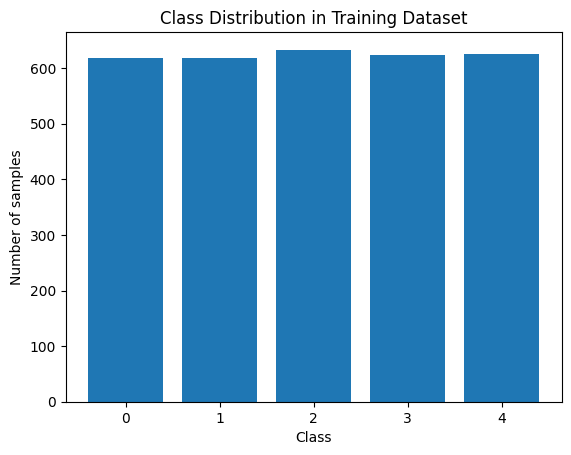

In [11]:
from collections import Counter

# For a dataset using ImageFolder or custom dataset with labels
labels = [label for _, label in train_dataset]  # for ImageFolder
class_counts = Counter(labels)

print("Class counts:", class_counts)

# Optional: visualize as bar plot
import matplotlib.pyplot as plt

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.bar(classes, counts)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class Distribution in Training Dataset")
plt.show()


In [13]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)

print("Train:", len(train_dataset), "Val:", len(val_dataset))

Train: 3120 Val: 780


In [14]:
# model --> mobilenetV3
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

mobileNet_small = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 219MB/s]


In [15]:
mobileNet_small.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

In [16]:
for param in mobileNet_small.features.parameters():
    param.requires_grad = False

In [17]:
import torch.nn as nn

    mobileNet_small.classifier = nn.Sequential(
        nn.Linear(576, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(512, 5)
    )


In [18]:
mobileNet_small.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=512, out_features=5, bias=True)
)

In [19]:
mobileNet_small = mobileNet_small.to(DEVICE)

In [20]:
# hyperparameters
learning_rate = 0.0001
epochs = 50

In [21]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobileNet_small.classifier.parameters(), lr=learning_rate, weight_decay=1e-4)

In [22]:
import numpy as np
import torch

class EarlyStoppingF1:
    def __init__(self, patience=5, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_f1 = -np.inf
        self.early_stop = False

    def __call__(self, val_f1):
        if val_f1 > self.best_f1 + self.min_delta:
            self.best_f1 = val_f1
            self.counter = 0
            if self.verbose:
                print(f"Validation F1 improved. Counter reset to 0.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"Validation F1 did not improve. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


In [23]:
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report

def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * (np.array(all_preds) == np.array(all_labels)).mean()
    bal_acc = 100 * balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")

    return acc, bal_acc, f1, classification_report(all_labels, all_preds, digits=4)


In [24]:
import torch.nn as nn
import torch.optim as optim
import copy

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize early stopping with your desired patience
early_stopping = EarlyStoppingF1(patience=5, verbose=True)

# To save the best model weights
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(mobileNet_small.state_dict())

for epoch in range(epochs):
    # --- Training Phase ---
    mobileNet_small.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = mobileNet_small(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Validation Phase ---
    mobileNet_small.eval()
    running_loss_val = 0.0

    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(DEVICE), labels_val.to(DEVICE)

            outputs_val = mobileNet_small(inputs_val)
            loss_val = criterion(outputs_val, labels_val)

            running_loss_val += loss_val.item()

            _, predicted_val = torch.max(outputs_val, 1)
            all_preds.extend(predicted_val.cpu().numpy())
            all_labels.extend(labels_val.cpu().numpy())

    epoch_val_loss = running_loss_val / len(val_loader)
    epoch_val_acc = 100 * (np.array(all_preds) == np.array(all_labels)).mean()
    epoch_val_bal_acc = 100 * balanced_accuracy_score(all_labels, all_preds)
    epoch_val_f1 = f1_score(all_labels, all_preds, average="macro")

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}% | "
          f"Val BalAcc: {epoch_val_bal_acc:.2f}% | Val F1: {epoch_val_f1:.4f}")

    # Save the best model based on validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(mobileNet_small.state_dict())

    # Check for early stopping
    early_stopping(epoch_val_f1)
    if early_stopping.early_stop:
        print("Early stopping triggered. Training stopped.")
        break

# Load the best model weights after training
mobileNet_small.load_state_dict(best_model_wts)
print("Best model weights loaded.")

Epoch 1/50 | Train Loss: 1.3673 | Train Acc: 43.21% | Val Loss: 1.3371 | Val Acc: 45.13% | Val BalAcc: 44.99% | Val F1: 0.4384
Validation F1 improved. Counter reset to 0.
Epoch 2/50 | Train Loss: 1.0858 | Train Acc: 56.12% | Val Loss: 1.2209 | Val Acc: 46.67% | Val BalAcc: 46.62% | Val F1: 0.4612
Validation F1 improved. Counter reset to 0.
Epoch 3/50 | Train Loss: 0.9646 | Train Acc: 63.72% | Val Loss: 1.1149 | Val Acc: 51.67% | Val BalAcc: 51.66% | Val F1: 0.5266
Validation F1 improved. Counter reset to 0.
Epoch 4/50 | Train Loss: 0.8799 | Train Acc: 67.21% | Val Loss: 0.9709 | Val Acc: 60.90% | Val BalAcc: 60.42% | Val F1: 0.5873
Validation F1 improved. Counter reset to 0.
Epoch 5/50 | Train Loss: 0.8170 | Train Acc: 69.65% | Val Loss: 0.8951 | Val Acc: 63.59% | Val BalAcc: 63.22% | Val F1: 0.6173
Validation F1 improved. Counter reset to 0.
Epoch 6/50 | Train Loss: 0.7642 | Train Acc: 71.63% | Val Loss: 0.8087 | Val Acc: 66.92% | Val BalAcc: 66.43% | Val F1: 0.6416
Validation F1 impr

In [25]:
torch.save(mobileNet_small.state_dict(), '/kaggle/working/best_weights_mod.pth')

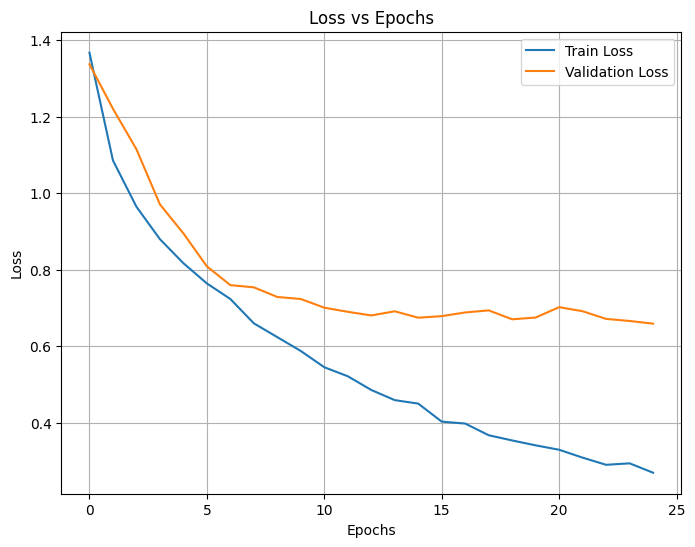

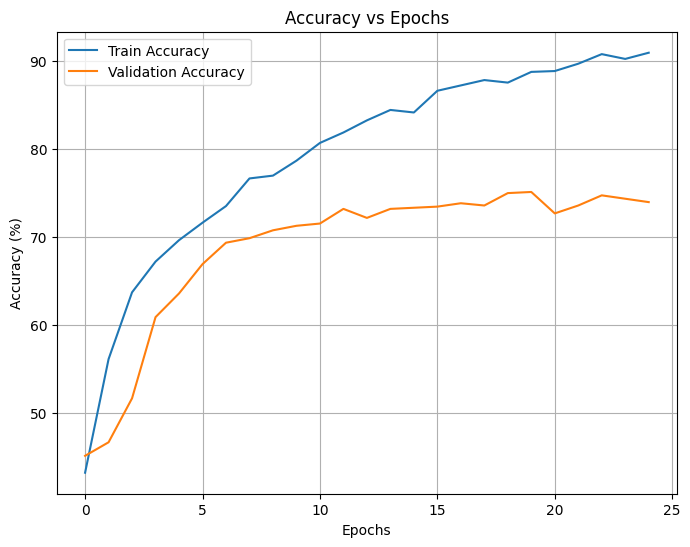

In [38]:
# --- Loss Plot ---
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/loss_plot.png', dpi=300)  # save before show
plt.show()

# --- Accuracy Plot ---
plt.figure(figsize=(8,6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/acc_plot.png', dpi=300)  # save before show
plt.show()


{'prediction': 'Mild DR', 'confidence': 0.5201787352561951}


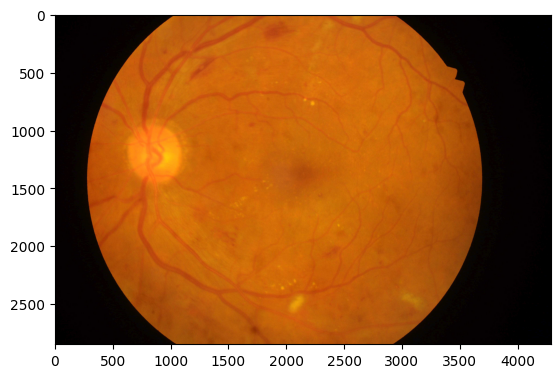

In [43]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# NUM_CLASSES = 5
# loaded_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
# loaded_model.classifier = nn.Sequential(
#     nn.Linear(576, out_features=288),
#     nn.Hardswish(),
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(288, out_features=NUM_CLASSES)
# )

# # Load the saved state dictionary
# model_path = 'best_mobilenet_model.pth' # Replace with the correct path to your saved model
# loaded_model.load_state_dict(torch.load(model_path))
# loaded_model.eval() # Important! Set model to evaluation mode

# # Use GPU if available
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# loaded_model = loaded_model.to(DEVICE)


def inference_on_image(image_path):
    """
    Performs inference on a single image using the loaded model.
    """
    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img)

    # Add a batch dimension (B x C x H x W)
    img_tensor = img_tensor.unsqueeze(0)

    # Move the tensor to the correct device
    img_tensor = img_tensor.to(DEVICE)

    # Perform inference without calculating gradients
    with torch.no_grad():
        outputs = mobileNet_small(img_tensor)

    # Get the predicted probabilities from the model's raw output
    probabilities = nn.functional.softmax(outputs, dim=1)[0]

    # Get the class with the highest probability
    predicted_class_index = torch.argmax(probabilities).item()
    confidence = probabilities[predicted_class_index].item()

    # Map the class index to a label
    class_labels = ["No DR", "Mild DR", "Moderate DR", "Severe DR", "Proliferative DR"]
    predicted_label = class_labels[predicted_class_index]

    return {
        "prediction": predicted_label,
        "confidence": confidence,
        # "class_probabilities": probabilities.tolist()
    }

def visualize(img_path):
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)

# Example usage:
image_to_test = '/kaggle/input/tttttdkljsf/IDRiD_013.jpg' # Change this to your image path
visualize(image_to_test)
results = inference_on_image(image_to_test)
print(results)

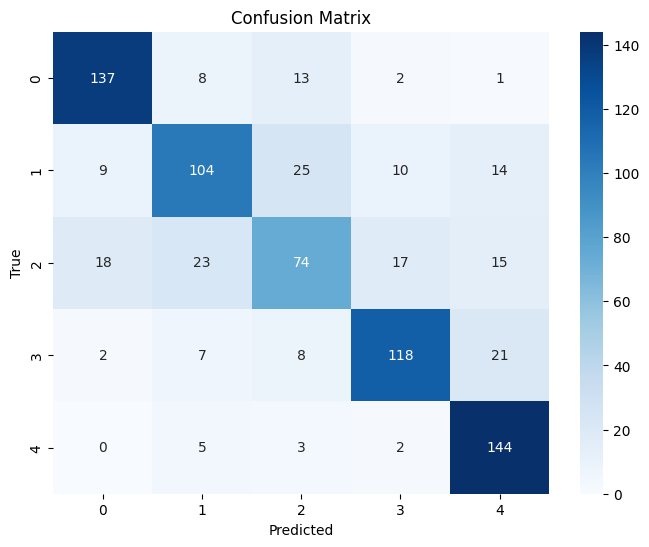

Classification Report:
              precision    recall  f1-score   support

           0     0.8253    0.8509    0.8379       161
           1     0.7075    0.6420    0.6731       162
           2     0.6016    0.5034    0.5481       147
           3     0.7919    0.7564    0.7738       156
           4     0.7385    0.9351    0.8252       154

    accuracy                         0.7397       780
   macro avg     0.7330    0.7376    0.7316       780
weighted avg     0.7349    0.7397    0.7337       780



In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Define class names ---
class_names = [str(i) for i in range(5)]  # 5 classes: 0,1,2,3,4

# --- Get predictions on validation set ---
mobileNet_small.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(DEVICE), labels_val.to(DEVICE)

        outputs_val = mobileNet_small(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)

        all_preds.extend(predicted_val.cpu().numpy())
        all_labels.extend(labels_val.cpu().numpy())

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=300)  
plt.show()

# --- Classification Report ---
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
